# Lecture Radiographies poumons, recherche pneumonies virales ou bactériennes, VGG16 Feature Extraction

## 0. Import des librairies

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import to_categorical, image_dataset_from_directory
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras import Model
from pathlib import Path
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [42]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [43]:
# Configurer TensorFlow pour utiliser le GPU et limiter la mémoire
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2000)])  # Limiter à 2GB
    except RuntimeError as e:
        print(e)

Virtual devices cannot be modified after being initialized


## 1. paramétrage 

In [44]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 8  # Réduire la taille du lot
EPOCHS = 10
CWD = Path.cwd()
NEW_TRAIN = CWD / "sorted_data" / "train"
NEW_VAL = CWD / "sorted_data" / "val"
NEW_TEST = CWD / "sorted_data" / "test"
class_names = {0: 'NORMAL', 1: 'VIRUS', 2: 'BACTERIA'}

## 2. Fonction de preprocessing adaptée au VGG16

In [45]:
# Fonction pour appliquer le prétraitement VGG16 à un dataset
def preprocess_dataset(dataset):
    return dataset.map(lambda x, y: (preprocess_input(x), y))

## 3. Chargement et preprocessing des datasets

In [46]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = image_dataset_from_directory(
    directory=NEW_TRAIN,
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
).cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
train_dataset = preprocess_dataset(train_dataset)

validation_dataset = image_dataset_from_directory(
    directory=NEW_VAL,
    labels='inferred',
    label_mode='int', 
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
).cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = preprocess_dataset(validation_dataset)

test_dataset = image_dataset_from_directory(
    directory=NEW_TEST,
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False,
).cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = preprocess_dataset(test_dataset)

Found 12485 files belonging to 3 classes.
Found 288 files belonging to 3 classes.
Found 822 files belonging to 3 classes.


## 4. Chargement du modèle VGG16 pré-entraîné

In [47]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

## 5. Définition du modèle (ajout de couches)

In [48]:
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)  # Réduire la taille des couches denses
x = Dropout(0.5)(x)
classifieur = Dense(3, activation='softmax')(x)  # 3 classes: NORMAL, BACTERIA, VIRUS
new_model = Model(inputs=base_model.input, outputs=classifieur)
new_model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,926,467 (68.38 MB)

 Trainable params: 17,926,467 (68.38 MB)

 Non-trainable params: 0 (0.00 B)

## 6. Feature Extraction, Geler les couches du modèle VGG16

In [49]:
for layer in base_model.layers:
    layer.trainable = False

new_model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,926,467 (68.38 MB)

 Trainable params: 3,211,779 (12.25 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

## 9. Compilation du modèle 

In [50]:
new_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

## 10. Configuration de l'EarlyStopping

In [51]:
es = EarlyStopping(
    monitor="val_accuracy", 
    mode="max", 
    patience=2,
    restore_best_weights=True)

## 11. Entraînement du modèle

In [52]:
history = new_model.fit(
    train_dataset, 
    validation_data=validation_dataset, 
    epochs=EPOCHS, 
    callbacks=[es],
    shuffle=True
)

Epoch 1/10
1561/1561 ━━━━━━━━━━━━━━━━━━━━ 78s 44ms/step - accuracy: 0.6024 - loss: 3.2497 - val_accuracy: 0.6250 - val_loss: 0.7027
Epoch 2/10
1561/1561 ━━━━━━━━━━━━━━━━━━━━ 67s 43ms/step - accuracy: 0.6670 - loss: 0.7201 - val_accuracy: 0.5486 - val_loss: 0.8439
Epoch 3/10
1561/1561 ━━━━━━━━━━━━━━━━━━━━ 67s 43ms/step - accuracy: 0.6804 - loss: 0.6663 - val_accuracy: 0.6042 - val_loss: 0.8072


## 12. Observation des courbes d'apprentissages

### Model Accuracy :
#### Train Accuracy : La précision du modèle sur les données d'entraînement à chaque époque.
#### Validation Accuracy : La précision du modèle sur les données de validation à chaque époque.
#### Interprétation :
- Si les deux courbes augmentent de manière stable et se rapprochent, le modèle apprend correctement.
- Si la courbe de validation commence à stagner ou à diminuer tandis que celle d'entraînement continue à augmenter, il peut y avoir un surapprentissage.
### Model Loss :
#### Train Loss : La perte du modèle sur les données d'entraînement à chaque époque.
#### Validation Loss : La perte du modèle sur les données de validation à chaque époque.
#### Interprétation :
- Si les deux courbes diminuent de manière stable et se rapprochent, le modèle converge correctement.
- Si la courbe de validation commence à augmenter tandis que celle d'entraînement continue à diminuer, il peut y avoir un surapprentissage.

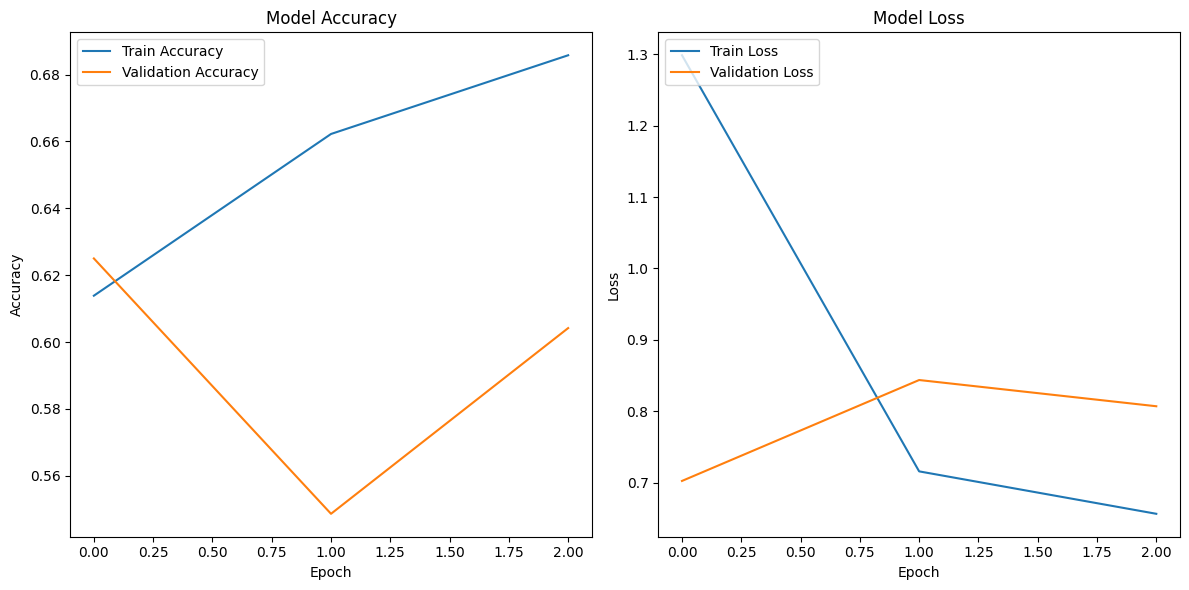

In [53]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

## 13. Evaluation du modèle sur le jeu de test

In [54]:
test_loss, test_accuracy = new_model.evaluate(test_dataset)
print(f"Loss on test dataset: {test_loss}")
print(f"Accuracy on test dataset: {test_accuracy}")

103/103 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.7475 - loss: 0.7256
Loss on test dataset: 0.7941018342971802
Accuracy on test dataset: 0.6751824617385864


## 14. Sauvegarde du modèle

In [55]:
new_model.save('my_model.keras')

2024-07-01 20:12:46.237667: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


103/103 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step


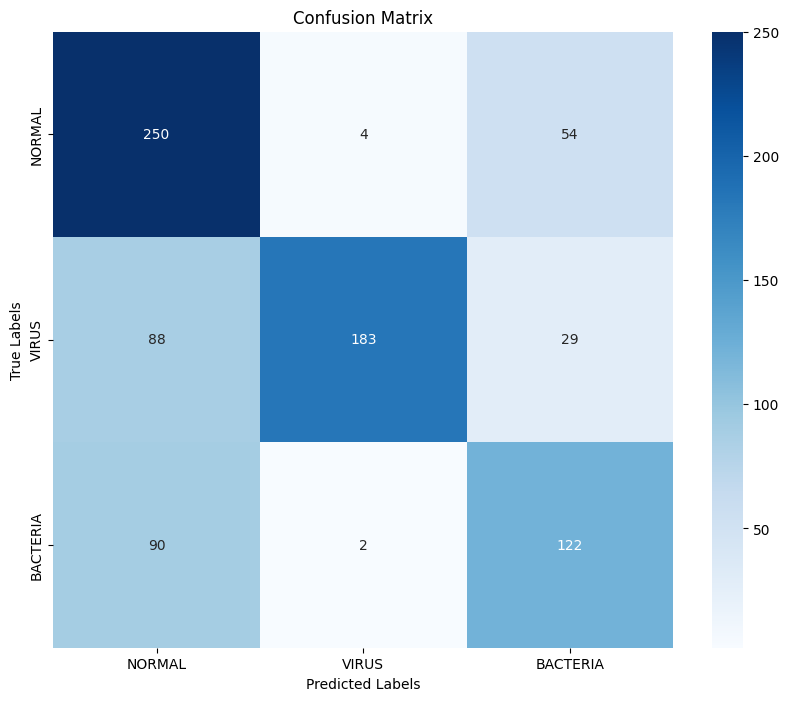

In [56]:
# Prédire les classes sur le jeu de test
test_labels = np.concatenate([y for x, y in test_dataset], axis=0)
predictions = new_model.predict(test_dataset)
predicted_labels = np.argmax(predictions, axis=1)

# Calculer la matrice de confusion
cm = confusion_matrix(test_labels, predicted_labels)

# Tracer la heatmap de la matrice de confusion
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names.values(), yticklabels=class_names.values())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()